In [4]:
from data_loader import OpenImagesDataset
from model_utils import device
from model_transformations import Transformations
from torch.utils.data import DataLoader
from params import NUM_EPOCHS, GRID_SIZE,IMAGE_SIZE, NUM_ANCHOR_BOXES, BATCH_SIZE
import torch.optim as optim
import torch
from model_loss import YoloLoss
from tqdm import tqdm
from model import DogDetectorModel
import numpy as np
from model_decoder import Decoder
from non_max_surpression import NonMaxSurpression
from true_box_extractor import true_box_extractor
from mean_average_precision import MAP
# torch.autograd.set_detect_anomaly(True)

In [5]:
# torch.autograd.detect_anomaly()

In [6]:
# Reading in the training data
trainingData = OpenImagesDataset(rootDirectory='open-images-v6', 
                                 anchorBoxes='centroids.npy', 
                                 transform=Transformations, 
                                 dataType='train', 
                                 gridSize=GRID_SIZE, 
                                 imageSize=IMAGE_SIZE)    

# Defining the training data
trainDataLoader = DataLoader(dataset=trainingData, 
                             batch_size=BATCH_SIZE,
                             num_workers=8,
                             shuffle=False)

# Reading in the training data
validationData = OpenImagesDataset(rootDirectory='open-images-v6', 
                                 anchorBoxes='centroids.npy', 
                                 transform=Transformations, 
                                 dataType='validation', 
                                 gridSize=GRID_SIZE, 
                                 imageSize=IMAGE_SIZE)    

# Defining the training data
validationDataLoader = DataLoader(dataset=trainingData, 
                             batch_size=BATCH_SIZE,
                             num_workers=8,
                             shuffle=True)

In [7]:
# Initializing the model
model = DogDetectorModel(gridSize=13, numAnchorBoxes=NUM_ANCHOR_BOXES)

In [ ]:
# Moving the model to the GPU
model = model.to(device)

/home/aidan/Programs/miniconda3/envs/dogapp/lib/python3.7/site-packages/torch/cuda/__init__.py:143: UserWarning: 
NVIDIA GeForce RTX 3070 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the NVIDIA GeForce RTX 3070 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [ ]:
# Defining the optimizer
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = optim.SGD(list(model.parameters()), lr=0.01, momentum=0.9, weight_decay=0.0005)
optimizer = optim.SGD(params, lr=0.0001, momentum=0.9)

In [ ]:
lossYolo = YoloLoss('centroids.npy', device)

In [ ]:
# modelInput, label = trainingData.__getitem__(15)

In [12]:
# modelInput = modelInput.reshape((1,3,416,416))

In [13]:
# label = label.reshape((1,13,13,35))

In [14]:
# loop =  tqdm(enumerate(trainDataLoader), total=len(trainDataLoader), leave=True)
# for batchIndex, (modelInput, label) in loop:
#     break

In [15]:
# Initializing the non max supressor for predictions
nonMaxSurpressionPredicted = NonMaxSurpression()

# Initializing the docoder
decoder = Decoder('centroids.npy', device)

In [16]:
bestMapValue=0

In [17]:
for epoch in range(0, 20):    
    # ****************** TRAINING ******************
    
    # Setting the model to training
    model.train()
    
    # Defining list to hold the mean loss
    meanLoss = []
    
    # Defining lists to hold all the predictions and ground truths for all elements in each batch
    predictedBoxesAllBatches = []
    trueBoxesAllBatches = []
    
    # Defining loop to get the nice progress bar
    loop =  tqdm(enumerate(trainDataLoader), total=len(trainDataLoader), leave=True)
    
    # Updating the output
    loop.set_description(f"Epoch: [{epoch+1}/{NUM_EPOCHS}]")   
    
    for batchIndex, (modelInput, label) in loop:

        # zero the parameter gradients
        optimizer.zero_grad()

        # Moving the model input/label to GPU 
        modelInput = modelInput.to(device)
        label = label.to(device)
        
        # Computing the model output
        output = model(modelInput)

        # Computing the loss
        loss = lossYolo(output, label)
        
        # Backpropogating the error
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(list(model.parameters()), 5)
        
        # Executing gradient descent
        optimizer.step()

        # Appending the loss to the list
        meanLoss.append(loss.item())

        with torch.no_grad():
            # Decoding the labels
            decodedLabel = decoder(torch.clone(label), 'label')
            
            # Decoding the output
            decodedOutput = decoder(torch.clone(output))    
            
            # Executing non max surpression on the decoded output to get the object detectiosn
            predictedBoxes = nonMaxSurpressionPredicted(decodedOutput)
            
            # Extracting the true bound boxes from the decoded label
            trueBoxes = true_box_extractor(label, decodedLabel)
            
            # Adding the detected boxes onto the list
            predictedBoxesAllBatches += predictedBoxes
            
            # Adding the true boxes onto the list
            trueBoxesAllBatches += trueBoxes
        loop.set_postfix(loss=loss.item())
     
        
        
    # Computing the MAP value
    mapValue = MAP(predictedBoxesAllBatches.copy(), trueBoxesAllBatches.copy())    
        
    print(f"====> Train Mean Loss: {sum(meanLoss)/len(meanLoss)}")
    print(f"====> Train MAP: {mapValue}")
                
    # ****************** VALIDATION ******************
    
    # Setting the model to evaluation mode
    model.eval()
    
    # Resetting lists from above
    meanLoss = []
    predictedBoxesAllBatches = []
    trueBoxesAllBatches = []
    
    # Turning of the gradient
    with torch.no_grad():
        
        # Defining loop to get the nice progress bar for the validation data
        loop =  tqdm(enumerate(validationDataLoader), total=len(validationDataLoader), leave=True)
        
        loop.set_description(f"Epoch: [{epoch+1}/{NUM_EPOCHS}]")   
        
        # Iterating through the batches of the validation data
        for batchIndex, [modelInput, label] in loop:

            # Moving the model input/label to GPU 
            modelInput = modelInput.to(device)
            label = label.to(device)

            # Computing the model output
            output = model(modelInput)
            
            # Computing the loss
            loss = lossYolo(output, label)
            
            # Appending the loss
            meanLoss.append(loss.item())
            
            # Decoding the labels
            decodedLabel = decoder(torch.clone(label), 'label')
            
            # Decoding the output
            decodedOutput = decoder(torch.clone(output))    
            
            # Executing non max surpression on the decoded output to get the object detectiosn
            predictedBoxes = nonMaxSurpressionPredicted(decodedOutput)
            
            # Extracting the true bound boxes from the decoded label
            trueBoxes = true_box_extractor(label, decodedLabel)
            
            # Adding the detected boxes onto the list
            predictedBoxesAllBatches += predictedBoxes
            
            # Adding the true boxes onto the list
            trueBoxesAllBatches += trueBoxes
            loop.set_postfix(loss=loss.item()) 
        
            
        # Computing the MAP value
        mapValue = MAP(predictedBoxesAllBatches.copy(), trueBoxesAllBatches.copy())    
        
        if mapValue > bestMapValue:
            print('Saving New Model')
            EPOCH = epoch
            PATH = "model.pt"
            LOSS = 0.4

            torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, PATH)
            
            
        print(f"====> Validation Loss: {sum(meanLoss)/len(meanLoss)}")
        print(f"====> Validation MAP: {mapValue}")
            


        
        
    

Epoch: [1/20]:   0%|▋                                                                                                                                                                                                                   | 2/667 [00:42<3:58:14, 21.50s/it, loss=4.7e+3]

KeyboardInterrupt



In [46]:
label[4].nonzero()

tensor([[ 9,  8, 20],
        [ 9,  8, 21],
        [ 9,  8, 22],
        [ 9,  8, 23],
        [ 9,  8, 24]], device='cuda:0')

In [49]:
# Decoding the labels
decodedLabel[4][ 9,  8, 20:25]

# Decoding the output
# decodedOutput = decoder(torch.clone(output))  

tensor([0.0000, 0.6923, 0.6154, 0.0000, 0.0000])

In [50]:
decodedOutput[4][ 9,  8, 20:25]

tensor([0.0033, 0.6162, 0.5449, 0.1874, 0.1662])

In [35]:
label[0][ 5, 6,10:15]

tensor([1.0000, 0.6658, 0.0613, 0.8700, 0.9312], device='cuda:0')

In [23]:
from model_utils import plot_tensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


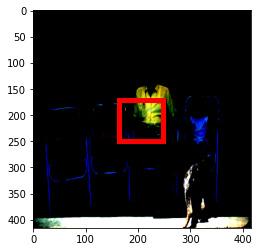

In [47]:
plot_tensor(modelInput[4].cpu(),decodedOutput[2][6, 6, 0:5].reshape(-1,5).cpu().numpy())